# Strain plots using one dataframe
In the other Notebook, I use several different dataframes to hold analyzed data, and it's pretty messy. In this Notebook, I want to clean things up and use only a few dataframes:
- Metadata from all trials
- Mitochondrial position information from all trials
    - experiment id
    - x, y, z coordinates
    - displacement in x, y, and z directions
    - particle id
    - frame number
    - acutation pressure
    - worm strain name
    - genotype
- Pairwise measurements from mitochondria
    - experiment id
    - pair id
    - particle ids
    - frame number
    - actuation pressure
    - worm strain name
    - current distance between pairs
    - rest distance between pairs
    - stretch
    - strain

## Setup
### Choose worm strain and neuron

In [1]:
worm_strains = ['NM3573', 'GN885', 'GN886', 'GN887', 'GN906']
neurons = ['ALM']

allele_dict = {'NM3573': 'wild-type',
               'GN885': 'him-4(e1267)',
               'GN886': 'mec-1(e1066)',
               'GN887': 'mec-1(e1738)',
               'GN906': 'mec-5(u444)'}

### Experimental parameters

In [2]:
pixel_to_micron = 0.275
analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_AnalyzedData/'
raw_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
fig_save_dir = analyzed_data_dir + 'PreliminaryPlots/'

### Import packages

In [3]:
import yaml
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import stats
from scipy.optimize import curve_fit
import pims
from nd2reader import ND2Reader 
import math
import warnings
import glob
import numpy as np
import typing
import pathlib
import seaborn as sns
import line_profiler

start = time.time()
for current_worm_strain in worm_strains:
    for current_neuron in neurons:
        current_strain_TRN = current_worm_strain + '_' + current_neuron
        fig_path = pathlib.Path(fig_save_dir + current_strain_TRN)
        if fig_path.exists() is False:
            fig_path.mkdir()

### Settings for plot aesthetics

In [4]:
sns.set(font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')

## Load data
### Start with metadata

In [5]:
analyzed_trials = glob.iglob(analyzed_data_dir + '*')
all_metadata = []
for trial in analyzed_trials:
    try:
        with open(trial + '/metadata.yaml') as metadata_file:
            all_metadata.append(yaml.safe_load(metadata_file))
    except FileNotFoundError:
        pass
    except NotADirectoryError:
        pass

metadata_df = pd.DataFrame(all_metadata)

#### Select only the trials that have been successfully processed
Also get a count of the number of trials for each genotype

In [6]:
trials_for_analysis = metadata_df.loc[(metadata_df['analysis_status'] == 'Strain calculated') &
                                                   (metadata_df['actuator_center'].notnull()) &
                                                   (metadata_df['neuron'].isin(neurons)) &
                                                   (metadata_df['worm_strain'].isin(worm_strains))].copy()

worm_strain_categories = pd.api.types.CategoricalDtype(categories=worm_strains, ordered=True)
trials_for_analysis['worm_strain'] = trials_for_analysis['worm_strain'].astype(worm_strain_categories)
trials_for_analysis.sort_values('worm_strain', inplace=True)
# display(trials_for_analysis)

n_trials_dict = trials_for_analysis['worm_strain'].value_counts().to_dict()

### Load mitochondria position data

In [7]:
list_of_linked_mito_dfs = []
linked_mitos_df = pd.DataFrame()
for index, row in trials_for_analysis.iterrows():
    experiment_id = row['Experiment_id']
    linked_mitos_file = analyzed_data_dir + experiment_id + '/mito_locations.yaml'
    with open(linked_mitos_file, 'r') as yamlfile:
        linked_mitos_dict = yaml.safe_load(yamlfile)

    parsed_dict = {k: linked_mitos_dict[k] for k in (
        'frame', 'particle', 'pressure', 'x', 'y', 'z')}
    parsed_df = pd.DataFrame(parsed_dict)
    parsed_df['Experiment_id'] = experiment_id
    parsed_df['worm_strain'] = row['worm_strain']
    parsed_df['genotype'] = allele_dict[row['worm_strain']]
    list_of_linked_mito_dfs.append(parsed_df)

linked_mitos_df = pd.concat(list_of_linked_mito_dfs)
linked_mitos_df['worm_strain'] = linked_mitos_df['worm_strain'].astype(worm_strain_categories)

## Find displacements from position data 
### Correct y value for actuator location and worm head direction
A y coordinate of 0 is the center of the actuator, and negative values correspond to the anterior side of the worm

In [8]:
def correct_y_value(row):
    current_metadata = trials_for_analysis.loc[trials_for_analysis['Experiment_id'] == row['Experiment_id']]

    if current_metadata['head_orientation'].str.contains('Headfirst').all():
        worm_head_direction = -1
    elif current_metadata['head_orientation'].str.contains('Tailfirst').all():
        worm_head_direction = 1
    else:
        raise ValueError

    yval_middle_of_actuator = current_metadata['actuator_center'].values[0][1]
    
    return worm_head_direction * (row['y'] - yval_middle_of_actuator)

linked_mitos_df['y'] = linked_mitos_df.apply(correct_y_value, axis=1)
# linked_mitos_df['y_pixel'] = linked_mitos_df['y']

### Convert coordinates from pixels to microns

In [ ]:
for coord in ['x', 'y', 'z']:
    linked_mitos_df[coord] = linked_mitos_df[coord] * pixel_to_micron

### Find rest locations
The rest location is the "undeformed" reference location for a particular mitochondrion. This is not truly undeformed since the worm is compressed in the trap, but it corresponds to the reference configuration for calculating strain

In [ ]:
def find_rest_locations(row, dimension):
    if row['pressure'] == 0:
        rest_dist = row[dimension]
    elif row['pressure'] != 0:
        rest_dist = linked_mitos_df.loc[
            (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
            (linked_mitos_df['frame'] == row['frame'] - 1) &
            (linked_mitos_df['particle'] == row['particle'])][dimension].values[0]
    
    return rest_dist

for dimension in ['x', 'y', 'z']:
    linked_mitos_df[dimension + '_rest'] = linked_mitos_df.apply(
        find_rest_locations, dimension=dimension, axis=1)

### Calculate displacements
The displacement of a mitochondrion is the distance between its current location and its rest location.

In [ ]:
def calc_distance(row, dimension):
    return distance.euclidean([row[dim] for dim in list(dimension)],
                              [row[dim + '_rest'] for dim in list(dimension)])

for dimension in ['x', 'y', 'z', 'xz', 'xyz']:
    linked_mitos_df[dimension + '_dist'] = linked_mitos_df.apply(
        calc_distance, dimension=dimension, axis=1)

def calc_displacement(row, dimension):
    return row[dimension] - row[dimension + '_rest']

for dimension in ['x', 'y', 'z']:
    linked_mitos_df[dimension + '_disp'] = linked_mitos_df.apply(
        calc_displacement, dimension=dimension, axis=1)

In [ ]:
# linked_mitos_df.loc[linked_mitos_df['pressure'] != 0].head()

### Fit gaussian to displacement profile to interpolate max displacement 

In [ ]:
def transformed_normal(x, loc, scale, mag):
    return mag * stats.norm.pdf(x, loc, scale)

def calc_max_dist_from_norm_fit(row):
    max_dist = transformed_normal(row['max_dist_location'],
                                  row['max_dist_location'],
                                  row['normal_scale_param'],
                                  row['normal_magnitude_param'])
    return max_dist

fit_param_list = []
for index, trial in trials_for_analysis.iterrows():
#     print(trial)
    trials_with_actuation = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == trial['Experiment_id']) &
        (linked_mitos_df['pressure'] == 300)]
    popt_norm, pcov_norm = curve_fit(
        transformed_normal,
        trials_with_actuation['y'],
        trials_with_actuation['x_dist'],
        p0=(0, 20, 400),
        maxfev=1000000)#,
#         bounds=((-5, 1, 50),
#                 (5, 100, 500)))
    fit_param_dict = {
        'Experiment_id': trial['Experiment_id'],
        'worm_strain': trial['worm_strain'],
        'genotype': allele_dict[trial['worm_strain']], 
        'max_dist_location': popt_norm[0],
        'normal_scale_param': popt_norm[1],
        'normal_magnitude_param': popt_norm[2]
    }
    fit_param_list.append(fit_param_dict)
fit_param_df = pd.DataFrame(fit_param_list)
fit_param_df['max_dist'] = fit_param_df.apply(calc_max_dist_from_norm_fit, axis=1)

### Correct y values using interpolated location of actuator center
By fitting a gaussian to the displacement profile, we get a value for how far the peak of the gaussian needed to be shifted. This is our best estimate of the center position of the actuator, since that is where the actuation is greatest. As a result, we correct the longitudinal coordinate again.

In [ ]:
def correct_y_using_fit(row, dimension):
    interpolated_center = fit_param_df.loc[
        fit_param_df['Experiment_id'] == row['Experiment_id']][
        'max_dist_location'].values[0]
    return row[dimension] - interpolated_center

linked_mitos_df['y'] = linked_mitos_df.apply(correct_y_using_fit, dimension='y', axis=1)
linked_mitos_df['y_rest'] = linked_mitos_df.apply(correct_y_using_fit, dimension='y_rest', axis=1)

## Plots of mitochondria locations and displacements

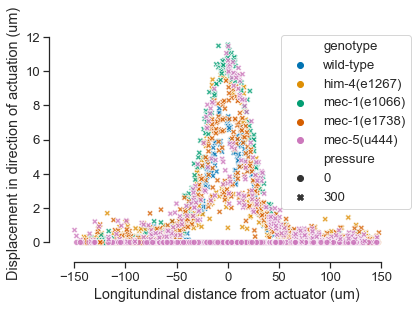

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x='y', y='x_dist', data=linked_mitos_df, hue='genotype', style='pressure', alpha=0.8)
sns.despine(ax=ax, offset=10, trim=True)
ax.set_xlabel('Longitundinal distance from actuator (um)')
ax.set_ylabel('Displacement in direction of actuation (um)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fig.savefig(fig_save_dir + 'x_disp_vs_position', bbox_inches='tight')

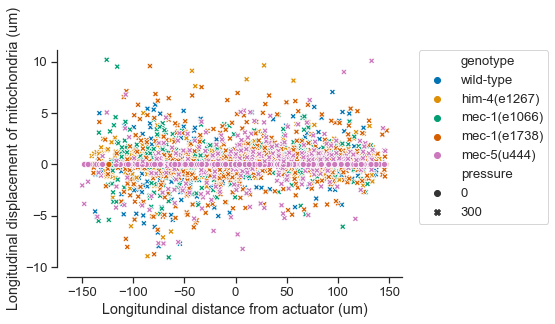

In [ ]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x='y', y='y_disp', data=linked_mitos_df, hue='genotype', style='pressure')
sns.despine(ax=ax, offset=10)
ax.set_xlabel('Longitundinal distance from actuator (um)')
ax.set_ylabel('Longitudinal displacement of mitochondria (um)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);

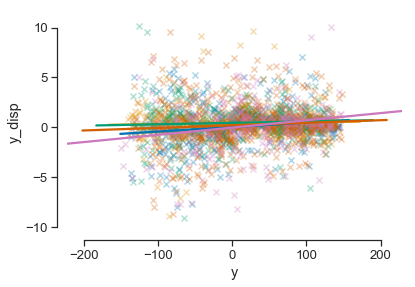

In [ ]:
fig, ax = plt.subplots()
# g = sns.jointplot(x='y', y='y_disp', #scatter_kws={'alpha':0.3},
#                data=linked_mitos_df.loc[(linked_mitos_df['pressure'] == 300) &
#                                          (linked_mitos_df['worm_strain'] == 'NM3573')])
# g = g.plot(sns.scatterplot, sns.distplot)
# g = sns.JointGrid(x="total_bill", y="tip", data=tips)

for this_strain in worm_strains:
    sns.regplot(x='y', y='y_disp', x_ci=None, ci=None, marker='x', scatter_kws={'alpha':0.3},
                data=linked_mitos_df.loc[(linked_mitos_df['pressure'] == 300) &
                                         (linked_mitos_df['worm_strain'] == this_strain)])
sns.despine(offset=10, trim=True)
# plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);



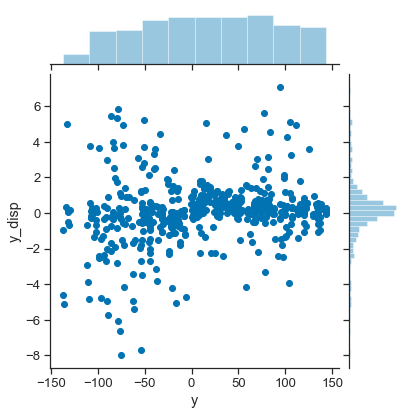

In [ ]:
g = sns.jointplot(y='y_disp', x='y',
                 data=linked_mitos_df.loc[(linked_mitos_df['pressure'] == 300) &
                                          (linked_mitos_df['worm_strain'] == 'NM3573')])

# sns.distplot

In [ ]:
fit_param_df.shape

(74, 7)

### Interpolated max displacement
This shouldn't vary between genotypes, since the actuator is applying the same displacement regardless of genotype.

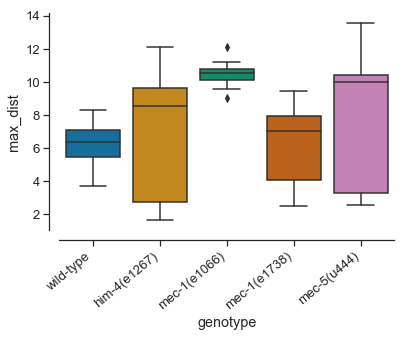

In [ ]:
ax = sns.boxplot(x='genotype', y='max_dist', data=fit_param_df)
labels = ax.get_xticklabels()
sns.despine(offset=10)
ax.set_xticklabels(labels, rotation=40, ha='right');

### Plot showing distribution of mitochondria along TRNs


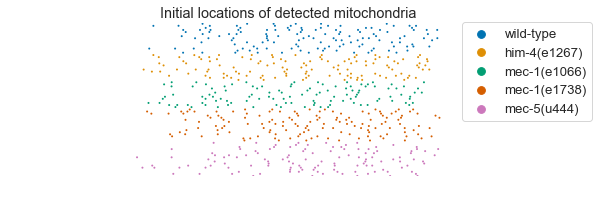

In [ ]:
ax = sns.stripplot(x='y', y='Experiment_id', hue='genotype', dodge=True, size=2,
              data=linked_mitos_df[linked_mitos_df['frame'] == 0])
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_aspect(2)
ax.axis('off')
ax.set_title('Initial locations of detected mitochondria');

### Plot showing how many mitochondria were tracked in each trial

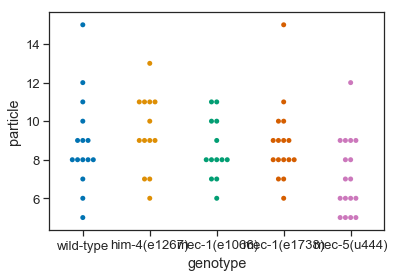

In [ ]:
particle_count_df = linked_mitos_df.loc[
    linked_mitos_df['frame'] == 0].groupby(
    ['Experiment_id', 'genotype'], as_index=False).count()
ax = sns.swarmplot(x='genotype', y='particle',
                  data=particle_count_df)
# particle_count_df['frame'].mean() #.describe()

### Number of frames per trial
We couldn't successfully track the position of the mitochondria through all stacks of every trial. This plot shows how many stacks were usable for the trials where some stacks were successfully analyzed.

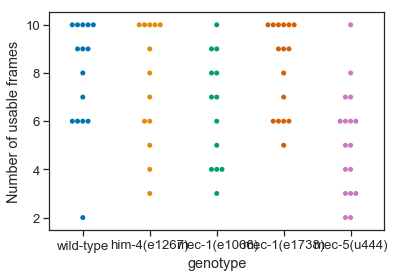

In [ ]:
ax = sns.swarmplot(x='genotype', y='frame',
                   data=linked_mitos_df.groupby('Experiment_id', as_index=False).max())
ax.set_ylabel('Number of usable frames');

### Plot displacement data along with fit

In [ ]:
# ax = sns.scatterplot(x='y', y='x_dist', 
#                      data=linked_mitos_df,#.loc[linked_mitos_df['Experiment_id']=='SSN_150_001'],
#                      hue='genotype', style='pressure')
# sns.despine(ax=ax, offset=10)
# ax.set_xlabel('Longitundinal distance from actuator (um)')
# ax.set_ylabel('Displacement in direction of actuation (um)')
# plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# plot_bounds = ax.get_xbound()
# x_coords =  np.linspace(round(plot_bounds[0]), round(plot_bounds[1]))
# for index, row in fit_param_df.iterrows():#[fit_param_df['Experiment_id']=='SSN_150_001'].iterrows():
#     color = ['b' if (row['worm_strain'] == 'NM3573') else 'r']
#     ax.plot(x_coords, transformed_normal(x_coords,
#                                          row['max_dist_location'],
#                                          row['normal_scale_param'],
#                                          row['normal_magnitude_param']),
#            color=color[0], alpha=0.1)

In [ ]:
# n = trials_for_analysis.shape[0]
# fig, axes = plt.subplots(n, 1, figsize=(5, n*4), constrained_layout=True)
# i=0
# for index, trial in trials_for_analysis.iterrows():
#     sns.scatterplot(x='y', y='x_dist', 
#                      data=linked_mitos_df.loc[linked_mitos_df['Experiment_id']==trial['Experiment_id']],
#                      hue='genotype', style='pressure', ax=axes[i])
#     axes[i].plot(x_coords, transformed_normal(
#         x_coords,
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['max_dist_location'].values[0],
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['normal_scale_param'].values[0],
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['normal_magnitude_param'].values[0]),
#            color='b')#, alpha=0.1)
# #     sns.scatterplot(x='original_y', y='x_dist', 
# #                      data=linked_mitos_df.loc[linked_mitos_df['Experiment_id']==trial['Experiment_id']],
# #                      hue='genotype', style='pressure', ax=axes[i], hue_order=[1,0])
#     linked_mitos_df.plot(x='original_y', y='x_dist', kind='scatter', color='r')
#     axes[i].plot(x_coords, transformed_normal(
#         x_coords,
#         0,
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['normal_scale_param'].values[0],
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['normal_magnitude_param'].values[0]),
#            color='r')#, alpha=0.1)
#     axes[i].set_title(trial['Experiment_id'])
#     i+=1
# # ax.set_ybound(-.1,.1)

In [ ]:
# # fit_param_df.boxplot('max_dist_location')
# sns.swarmplot(y='max_dist_location', data=fit_param_df)

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     print(df)
#     display(linked_mitos_df)

## Create dataframe with data for pairs of adjacent mitochondria
- experiment id
- pair id
- particle ids
- frame number
- actuation pressure
- worm strain name
- genotype
- current distance between pairs
- stretch
- strain
### Match adjacent mitochondria into pairs

In [ ]:
def make_pairs_df(df_with_linked_mitos):
    mito_pair_df_list = []
    df_with_linked_mitos.sort_values(['worm_strain', 'Experiment_id', 'frame', 'y'], inplace=True)
    for trial in df_with_linked_mitos['Experiment_id'].unique():
        for frame in df_with_linked_mitos.loc[df_with_linked_mitos['Experiment_id'] == trial]['frame'].unique():
            pair_count = 0
            # create iterrator to go through the particles of only this frame
            iterrator = df_with_linked_mitos.loc[
                    (df_with_linked_mitos['Experiment_id'] == trial) &
                    (df_with_linked_mitos['frame'] == frame)].iterrows() 
            # skip the first one, since we want to make pairs
            previous_index, previous_row = next(iterrator)
            for index, row in iterrator:
                this_dist = distance.euclidean(previous_row[['x', 'y', 'z']], row[['x', 'y', 'z']])
                rest_dist = distance.euclidean(
                    previous_row[['x_rest', 'y_rest', 'z_rest']], row[['x_rest', 'y_rest', 'z_rest']])
                this_mito_pair_dict = {
                    'Experiment_id': row['Experiment_id'],
                    'frame': row['frame'],
                    'particle_1': previous_row['particle'],
                    'particle_1_yval': previous_row['y'],
                    'particle_2': row['particle'],
                    'particle_2_yval': row['y'],
                    'pair_id': pair_count,
                    'pressure': row['pressure'],
                    'worm_strain': row['worm_strain'],
                    'genotype': row['genotype'],
                    'distance': this_dist,
                    'rest_dist': rest_dist,
                    'timestamp': trials_for_analysis.loc[
                        trials_for_analysis['Experiment_id'] == row['Experiment_id']]['timestamp'].values[0]}
                for dim in ['x', 'y', 'z']:
                    this_mito_pair_dict[dim + '_dist'] = distance.euclidean(previous_row[dim], row[dim])
                    this_mito_pair_dict[dim + '_rest_dist'] = distance.euclidean(
                        previous_row[dim + '_rest'],
                        row[dim + '_rest'])
                mito_pair_df_list.append(this_mito_pair_dict)
                pair_count += 1
                previous_row = row

    df_with_mito_pairs = pd.DataFrame(mito_pair_df_list)
    df_with_mito_pairs['worm_strain'] = df_with_mito_pairs['worm_strain'].astype(worm_strain_categories)
    df_with_mito_pairs.sort_values('worm_strain', inplace=True)
    
    return df_with_mito_pairs

mito_pair_df = make_pairs_df(linked_mitos_df)

In [ ]:
mito_pair_df.columns

Index(['Experiment_id', 'distance', 'frame', 'genotype', 'pair_id',
       'particle_1', 'particle_1_yval', 'particle_2', 'particle_2_yval',
       'pressure', 'rest_dist', 'timestamp', 'worm_strain', 'x_dist',
       'x_rest_dist', 'y_dist', 'y_rest_dist', 'z_dist', 'z_rest_dist'],
      dtype='object')

### Calculate stretch and strain

In [ ]:
def calc_stretch(row):
    return row['distance'] - row['rest_dist']

def calc_strain(row):
    return row['stretch'] / row['rest_dist']

mito_pair_df['stretch'] = mito_pair_df.apply(calc_stretch, axis=1)
mito_pair_df['strain'] = mito_pair_df.apply(calc_strain, axis=1)

### Estimate uncertainty by calculating strain in frames with no actuation
In a perfect measurement, the distance between mitos should be the same in all stacks where the actuation is off, since there is no stimulus. In reality, the worm in the device can move on its own, so this is not true. To estimate the uncertainty of our strain measurement, we use the most recent stack where the actuation was off as the rest condition and calculate strain.

In [ ]:
mito_pairs_pressure_off = make_pairs_df(linked_mitos_df.loc[linked_mitos_df['pressure'] == 0].copy())

for index, row in mito_pairs_pressure_off.iterrows():
    if row['frame'] != 0:
        mito_pairs_pressure_off.loc[index, 'rest_dist'] = mito_pairs_pressure_off.loc[
            (mito_pairs_pressure_off['Experiment_id'] == row['Experiment_id']) &
            (mito_pairs_pressure_off['frame'] == row['frame'] - 2) &
            (mito_pairs_pressure_off['pair_id'] == row['pair_id'])]['distance'].values[0]
        for dim in ['x', 'y', 'z']:
            mito_pairs_pressure_off.loc[index, (dim + '_rest_dist')] = mito_pairs_pressure_off.loc[
                (mito_pairs_pressure_off['Experiment_id'] == row['Experiment_id']) &
                (mito_pairs_pressure_off['frame'] == row['frame'] - 2) &
                (mito_pairs_pressure_off['pair_id'] == row['pair_id'])][dim + '_dist'].values[0]

mito_pairs_pressure_off['stretch'] = mito_pairs_pressure_off.apply(calc_stretch, axis=1)
mito_pairs_pressure_off['strain'] = mito_pairs_pressure_off.apply(calc_strain, axis=1)

In [ ]:
try:
    pd.testing.assert_frame_equal(
        mito_pairs_pressure_off.reset_index(drop=True),
        mito_pair_df.loc[mito_pair_df['pressure'] == 0].reset_index(drop=True), check_names=False)
except:
    # we should get here, since the dataframes should be different
    pass
else:
    raise AssertionError

### Get spatial distribution of strain

In [ ]:
spatial_strain_avg_list = []
for index, row in mito_pair_df.iterrows():
    y1_pixel = math.ceil(row['particle_1_yval'] / pixel_to_micron)
    y2_pixel = math.floor(row['particle_2_yval'] / pixel_to_micron)
    for y_coord in range(y1_pixel, y2_pixel):
        new_row_dict = {
            'Experiment_id': row['Experiment_id'],
            'frame': row['frame'],
            'pair_id': row['pair_id'],
            'pressure': row['pressure'],
            'worm_strain': row['worm_strain'],
            'genotype': row['genotype'],
            'stretch': row['stretch'],
            'strain': row['strain'],
            'y_coord': y_coord,
            'y': y_coord * pixel_to_micron}
        spatial_strain_avg_list.append(new_row_dict)
            
spatial_strain_df = pd.DataFrame(spatial_strain_avg_list)
spatial_strain_df['worm_strain'] = spatial_strain_df['worm_strain'].astype(worm_strain_categories)
spatial_strain_df.sort_values('worm_strain', inplace=True)

## Plots of strain
### Plot strain at middle of actuator

In [ ]:
central_mito_pair_df = mito_pair_df.loc[
    ((mito_pair_df['particle_1_yval'] < 0) != 
     (mito_pair_df['particle_2_yval'] < 0)) &
    (mito_pair_df['pressure'] != 0)].copy()
central_mito_pair_df['worm_strain'] = central_mito_pair_df['worm_strain'].astype(worm_strain_categories)
central_mito_pair_df.sort_values('worm_strain', inplace=True)

mito_pair_adj_to_actuator_df = mito_pair_df.loc[
    ((mito_pair_df['particle_1_yval'] < 50) != 
     (mito_pair_df['particle_2_yval'] < 50)) &
    (mito_pair_df['pressure'] != 0)].copy()
central_mito_pair_df['worm_strain'] = central_mito_pair_df['worm_strain'].astype(worm_strain_categories)
central_mito_pair_df.sort_values('worm_strain', inplace=True)


n_actuations = {}
for this_strain in worm_strains:
    n_by_strain = central_mito_pair_df[central_mito_pair_df['worm_strain'] == this_strain].shape[0]
    n_actuations[allele_dict[this_strain]] = n_by_strain

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='genotype', y='stretch', data=central_mito_pair_df, ax=ax)
sns.swarmplot(x='genotype', y='stretch', color=".25", data=central_mito_pair_df, ax=ax)
# ax.legend(ax.artists, worm_strains)
fig.suptitle('TRN stretch at center of actuator')
sns.despine(offset=10, trim=True)
# n_trials_text = [allele_dict[strain_name] + ': ' for strain_name in worm_strains]
# text_obj = mpl.offsetbox.AnchoredText(n_trials_text, loc="upper right", frameon=False)
# ax.add_artist(text_obj)
# ax.set_xlabel(('x1', 'x2'))

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2 = sns.boxplot(x='genotype', y='strain', data=central_mito_pair_df, ax=ax2, color='white')
sns.stripplot(x='genotype', y='strain', hue='Experiment_id', ax=ax2, palette='tab20',
              data=central_mito_pair_df)
fig2.suptitle('TRN strain at center of actuator')
sns.despine(offset=10, trim=True)
# ax2.get_legend().remove()
# ax2.legend(ax2.artists, worm_strains)
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);
fig2.savefig(fig_save_dir + 'StrainAtCenter')

print(time.time()-start)

In [ ]:
central_mito_pair_df

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='Experiment_id', y='strain', hue='worm_strain', ax=ax,
              data=central_mito_pair_df.sort_values('worm_strain'))
ax.legend(ax.artists, worm_strains)
sns.boxplot(x='Experiment_id', y='strain', hue='worm_strain', ax=ax,
            data=central_mito_pair_df.sort_values('worm_strain'))
fig.suptitle('TRN strain at center of actuator')
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha='right');

### One-way ANOVA to test for statistical significance

In [ ]:
center_strain_input = []
for this_worm_strain in worm_strains:
    center_strain_input.append(central_mito_pair_df.loc[
        central_mito_pair_df['worm_strain'] == this_worm_strain]['strain'])

stats.f_oneway(*center_strain_input)

### Strain at center vs. time

In [ ]:
fig, ax = plt.subplots()
sns.despine(offset=10)
for this_strain in worm_strains:
    sns.regplot(x='frame', y='strain', ax=ax,
                data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == this_strain])

### Plot strain using spatial averaging

In [ ]:
plot_start = time.time()
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.lineplot(x='y', y='strain', ax=ax, hue='worm_strain', ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
                                        (spatial_strain_df['y'] > -50) &
                                        (spatial_strain_df['y'] < 100)])

sns.despine(offset=10, trim=True)
h, labels = ax.get_legend_handles_labels()
labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
ax.legend(h, labels)
ax.set_xlabel('Distance from center of actuator')
# ax.set_xlim((-50, 100))
# ax.set_ylim((-0.05, 0.10))
fig.savefig(fig_save_dir + 'StrainVsPosition')
print('Plot took', str(round(time.time()-plot_start)), 'seconds.')

### Plot components of strain

In [ ]:
# plot_start = time.time()
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,15), constrained_layout=True)
# sns.lineplot(x='y', y='x_strain', ax=axes[0], hue='worm_strain', ci=None,# dashes='',
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300)])
# axes[0].set_ylabel('Strain in direction of actuation')
# sns.lineplot(x='y', y='y_strain', ax=axes[1], hue='worm_strain', ci=None,# style=[(4,4)],
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300)])
# axes[1].set_ylabel('Strain in longitudinal axis of worm')
# sns.lineplot(x='y', y='z_strain', ax=axes[2], hue='worm_strain', ci=None,# style=[(1,1)],
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300)])
# axes[2].set_ylabel('Strain in z direction')

# for ax in axes:
#     h, labels = ax.get_legend_handles_labels()
#     labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
#     ax.legend(h, labels)
#     ax.set_xlabel('Distance from center of actuator')
#     sns.despine(offset=10, trim=True)

# # print('Plot took', str(round(time.time()-plot_start)), 'seconds.')

### Plot stretch using spatial averaging

In [ ]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.lineplot(x='y', y='stretch', ax=ax, hue='worm_strain', ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
                                        (spatial_strain_df['y'] > -50) &
                                        (spatial_strain_df['y'] < 100)])

sns.despine(offset=10, trim=True)
h, labels = ax.get_legend_handles_labels()
labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
ax.legend(h, labels)
ax.set_xlabel('Distance from center of actuator');

### Plot components of stretch

In [ ]:
# plot_start = time.time()
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,15), constrained_layout=True)
# sns.lineplot(x='y', y='x_stretch', ax=axes[0], hue='worm_strain', ci=None,# dashes='',
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300)])
# axes[0].set_ylabel('Stretch in direction of actuation')
# sns.lineplot(x='y', y='y_stretch', ax=axes[1], hue='worm_strain', ci=None,# style=[(4,4)],
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300)])
# axes[1].set_ylabel('Stretch in longitudinal axis of worm')
# sns.lineplot(x='y', y='z_stretch', ax=axes[2], hue='worm_strain', ci=None,# style=[(1,1)],
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300)])
# axes[2].set_ylabel('Stretch in z direction')

# for ax in axes:
#     h, labels = ax.get_legend_handles_labels()
#     labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
#     ax.legend(h, labels)
#     ax.set_xlabel('Distance from center of actuator')
#     ax.set_ylim([-2, 4])
# sns.despine(offset=10, trim=True)

# # print('Plot took', str(round(time.time()-plot_start)), 'seconds.')

### Spatial distribution of strain from a single genotype

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='y', y='strain', ax=ax, hue='Experiment_id', style='frame', # ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
                                        (spatial_strain_df['worm_strain'] == 'GN886') &
                                        (spatial_strain_df['y'] > -50) &
                                        (spatial_strain_df['y'] < 100)])

sns.despine(offset=10, trim=True)
ax.legend()
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax.set_xlabel('Distance from center of actuator');

Need to check SSN_255_001, SSN_220_001, and SSN_210_001 for outlier problems

### Max displacement vs. max strain

In [ ]:
def get_strain_at_actuator(row):
    strain_val = spatial_strain_df.loc[
        (spatial_strain_df['Experiment_id'] == row['Experiment_id']) &
        (spatial_strain_df['pressure'] != 0) &
        (spatial_strain_df['y_coord'] == 0)]['strain'].mean()
    return strain_val    

fit_param_df['strain_at_actuator'] = fit_param_df.apply(get_strain_at_actuator, axis=1)

def get_max_dist_to_central_pair_df(row):
    max_dist = fit_param_df.loc[
        (fit_param_df['Experiment_id'] == row['Experiment_id'])]['max_dist'].values[0]
    
    return max_dist

central_mito_pair_df['max_dist'] = central_mito_pair_df.apply(get_max_dist_to_central_pair_df, axis=1)

# fig, ax = plt.subplots(constrained_layout=True)
# for this_strain in worm_strains:
#     sns.regplot(x='max_dist', y='strain_at_actuator', x_ci=None, ci=None, # hue='genotype',
#                 data=fit_param_df.loc[fit_param_df['worm_strain'] == this_strain])
fig = sns.lmplot(x='max_dist', y='strain_at_actuator', hue='genotype', ci=None,
               truncate=True, data=fit_param_df)
sns.despine(offset=10)
fig.set_axis_labels('Max interpolated displacement (um)', 'Strain in middle of actuator')
# ax.set_title('Strain vs. max displacement')
# ax.set_xlabel('Max interpolated displacement (um)')
# ax.set_ylabel('Strain in middle of actuator')
# ax.legend(['wild-type', 'him-4(e1267)', 'mec-1(e1066)', 'mec-1(e1738)'])

fig.savefig(fig_save_dir + 'strain_vs_max_displacement')



### Strain in frames with no actuation
Useful for estimating uncertainty of touch-induced mechanical strain measurement

In [ ]:
central_mito_pair_pressure_off = mito_pairs_pressure_off.loc[
    ((mito_pair_df['particle_1_yval'] < 0) != 
     (mito_pair_df['particle_2_yval'] < 0)) &
    (mito_pair_df['pressure'] != 0)].copy()
central_mito_pair_pressure_off['worm_strain'] = central_mito_pair_pressure_off['worm_strain'].astype(worm_strain_categories)
central_mito_pair_pressure_off.sort_values('worm_strain', inplace=True)

# n_actuations = {}
# for this_strain in worm_strains:
#     n_by_strain = central_mito_pair_df[central_mito_pair_df['worm_strain'] == this_strain].shape[0]
#     n_actuations[allele_dict[this_strain]] = n_by_strain

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='genotype', y='stretch', data=central_mito_pair_pressure_off, ax=ax)
sns.swarmplot(x='genotype', y='stretch', color=".25", data=central_mito_pair_pressure_off, ax=ax)
# ax.legend(ax.artists, worm_strains, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fig.suptitle('TRN stretch at center of actuator with no stimulus')
sns.despine(offset=10, trim=True)

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2 = sns.boxplot(x='genotype', y='strain', data=central_mito_pair_pressure_off, ax=ax2, color='white')
sns.stripplot(x='genotype', y='strain', hue='Experiment_id', ax=ax2, palette='tab20',
              data=central_mito_pair_pressure_off)
fig2.suptitle('TRN strain at center of actuator with no stimulus')
sns.despine(offset=10, trim=True)
# ax2.get_legend().remove()
# ax2.legend(ax2.artists, worm_strains)
ax2.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);

### Check for effect of movement on noise
Check hypothesis that trials with more movement in the longitudinal direction of the worm have more variation in strain measurement.

## Exploratory data analysis

In [ ]:
sns.jointplot(x='max_dist', y='strain_at_actuator', data=fit_param_df);

In [ ]:
fig, ax = plt.subplots(figsize=(10,2))
for strain in worm_strains:
    sns.distplot(a=spatial_strain_df.loc[
        (spatial_strain_df['worm_strain'] == strain) &
        (spatial_strain_df['pressure'] != 0)]['y'], kde=False,
                 hist_kws={'histtype': 'step'}, ax=ax,
                 bins=spatial_strain_df['y'].sort_values().unique()+pixel_to_micron/2)
ax.set_xlabel('Distance from center of actuator (um)')
ax.set_ylabel('Number of actuation events')
sns.despine(offset=10)

In [ ]:
ax = sns.scatterplot(x='timestamp', y='strain', data=central_mito_pair_df)
ax.set_xlim((central_mito_pair_df['timestamp'].min(), central_mito_pair_df['timestamp'].max()))
first_timestamp = central_mito_pair_df['timestamp'].min()
last_timestamp = central_mito_pair_df['timestamp'].max()
labels = [time for time in pd.date_range(start=first_timestamp, end=last_timestamp, freq='MS', normalize=True)]
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation=40, ha='right');

In [ ]:
# linked_mitos_df.groupby(['genotype']).count()
ax = sns.countplot(x='genotype', data=central_mito_pair_df)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=40, ha='right')
ax.set_ylabel('Number of actuation events');

## Plots for figure 1 of paper
This figure is intended to show how the method for measuring strain works. I've chosen a trial with the maximum number of actuation events so it can be averaged.

- A) Max projection of mitochondria in the TRN of a worm. 
- B) Motion of mitochondria induced by mechanical stimulus. 
- C) Mechanical strain in the TRN at the location of maximum actuation. 
- D) Distribution of touch-induced strain in the TRN

In [ ]:
example_trial = 'SSN_161_001'
timestamp = metadata_df.loc[metadata_df['Experiment_id'] == example_trial]['timestamp'].values[0]
exp_dir = ''.join(str(timestamp)[:10].split('-'))
filename = pathlib.Path(raw_data_dir, exp_dir, example_trial + '.nd2')
bf_filename = filename.parent.joinpath(filename.stem + '_bf.nd2')
warnings.filterwarnings("ignore", message="Reported average frame interval")

In [ ]:
bf_image = pims.open(str(bf_filename))
bf_array = np.asarray(bf_image)
bf_array = bf_array.squeeze()
bf_array = np.rot90(bf_array,1,(0,1))

In [ ]:
images = pims.open(str(filename))
images.bundle_axes = ['z', 'y', 'x']

imageArray = np.asarray(images)
imageArray = imageArray.squeeze()

maxProjection = np.amax(imageArray[0:2] ,1) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)
maxProjection = np.rot90(maxProjection,1,(1,2))

In [ ]:
sns.set(font_scale=1)
sns.set_style(style='ticks')
sns.set_palette('colorblind')
sns.set_context('paper', rc={"font.size":12,
                             "axes.titlesize":10,
                             "axes.labelsize":10,
                             'legend.fontsize': 8,
                             'legend.title_fontsize': 8})

# Corrections for coordinates of image and data
middle_actuator_estimate = trials_for_analysis.loc[
    trials_for_analysis['Experiment_id'] == example_trial]['actuator_center'].values[0][1] * pixel_to_micron
disp_fit_correction = fit_param_df.loc[
        fit_param_df['Experiment_id'] == row['Experiment_id']][
        'max_dist_location'].values[0]
left_side_of_image = 0 - (middle_actuator_estimate + disp_fit_correction)
right_side_of_image = maxProjection.shape[2] * pixel_to_micron + left_side_of_image
top_of_image = 300
bottom_of_image = 450
actuator_left = 490
actuator_width = 160
actuator_right = actuator_left + actuator_width
actuator_top = 100
bf_image_top = 75
bf_image_bottom = -150
scale_bar_length_microns = 20

# Colors and display settings
vmax = 150
vmin = maxProjection.min()
n_colors = vmax - vmin + 1
magenta_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_magenta', ['white', '#FF00FF'], N=256)
magenta_patch = mpl.patches.Patch(color='#FF00FF', label='0 kPa')
green_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_green', ['white', '#00FF00'], N=256)
green_patch = mpl.patches.Patch(color='#00FF00', label='300 kPa')
spectrum_for_actuation = mpl.colors.LinearSegmentedColormap.from_list('my_spec', ['#FF00FF', '#00FF00'], N=256)

# Create Figure
fig, axes = plt.subplots(4, 2, figsize=(5, 5), constrained_layout=False,
                         gridspec_kw={'height_ratios':[2.5, 1, 1.5, 1.5], 'width_ratios':[1,6], 'hspace':0.3})

# Panel Labels
for letter, ax in zip(['A', 'B', 'C', 'D'], range(0,4)):
    axes[ax, 0].text(0, 1, letter, weight='bold')
    axes[ax, 0].axis('off')

# Brightfield image of worm in device
axes[0, 1].imshow(np.fliplr(bf_array[bf_image_top:bf_image_bottom]), cmap='gray_r') # try top_of_image:bottom_of_image to see how that looks
# dotted line to show subset of image used for next panel
axes[0, 1].plot([1, 1, bf_array.shape[1]-1, bf_array.shape[1]-1, 1],
             [bottom_of_image-bf_image_top, top_of_image-bf_image_top,
              top_of_image-bf_image_top, bottom_of_image-bf_image_top, bottom_of_image-bf_image_top], '--k')
scale_bar = mpl.patches.Rectangle((50, 25), height=10,
                                  width=scale_bar_length_microns/pixel_to_micron, facecolor='black')
axes[0, 1].add_patch(scale_bar)
axes[0, 1].axis('off')


# Overlay of fluorescence image of mitos before and after actuation
axes[1, 1].imshow(np.fliplr(maxProjection[0, top_of_image:bottom_of_image,]),
               cmap=magenta_cmap, alpha=1, vmax=vmax, vmin=vmin) # before actuation
axes[1, 1].imshow(np.fliplr(maxProjection[1, top_of_image:bottom_of_image,]),
               cmap=green_cmap, alpha=0.7, vmax=vmax, vmin=vmin) # after actuation
axes[1, 1].plot([actuator_left, actuator_left, actuator_right, actuator_right],
             [bottom_of_image-top_of_image, actuator_top, actuator_top, bottom_of_image-top_of_image], '-k')
arc = mpl.patches.Arc(((actuator_left+actuator_right)/2, actuator_top),
                      actuator_right-actuator_left, 30, 0, 180,
                      linewidth=1, color='black', linestyle='--') # diagram of actuator location
axes[1, 1].add_patch(arc)
scale_bar = mpl.patches.Rectangle((50, 100), height=10, 
                                  width=scale_bar_length_microns/pixel_to_micron, facecolor='black')
axes[1, 1].add_patch(scale_bar)
axes[1, 1].axis('off')

sns.scatterplot(x='y', y='x_dist', hue='pressure', ax=axes[2, 1], palette=spectrum_for_actuation, legend=None,
                data=linked_mitos_df.loc[(linked_mitos_df['Experiment_id']==example_trial) & 
                                         (linked_mitos_df['frame'] <= 1)])
axes[2, 1].set_xlim([left_side_of_image, right_side_of_image])
# axes[2].set_xlabel('Longitundinal distance from actuator (um)')
axes[2, 1].set_ylabel('Disp (um)')
leg = axes[2, 1].legend([magenta_patch, green_patch], ['0 kPa', '300 kPa'],
                        title='Pressure', frameon=False, loc='upper right', fontsize=8,
                        bbox_to_anchor=(1., 1.2), borderaxespad=0.)
leg.get_title().set_fontsize(8)

axes[2, 1].get_xaxis().set_visible(False)
sns.despine(ax=axes[2, 1], offset=10, trim=False, bottom=True)


sns.lineplot(x='y', y='strain', hue='genotype', style='pressure', ax=axes[3, 1], ci=None, palette=None,
                data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
                                           (spatial_strain_df['Experiment_id'] == example_trial) &
                                           (spatial_strain_df['frame'] == 1)])
# sns.lineplot(x='y', y='strain', hue='genotype', style='frame', dashes=[(3,3),(3,3),(3,3),(3,3),],
#              ax=axes[3, 1], ci=None, palette=None, alpha=0.5,
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
#                                            (spatial_strain_df['Experiment_id'] == example_trial)])
axes[3, 1].set_xlim([left_side_of_image, right_side_of_image])
axes[3, 1].set_xlabel('Longitundinal distance from actuator (um)')
axes[3, 1].set_ylabel('Strain')
axes[3, 1].legend().set_visible(False)
sns.despine(ax=axes[3, 1], offset=10, trim=False)


# Save fig
fig.align_labels()
fig.savefig(fig_save_dir + 'DispOverlay.pdf')


## Plots for figure 2 of paper
This figure shows what the strain profile of wild-type worms.

- A) Spatially averaged strain profile
- B) Plot of strain vs displacement at actuator

In [ ]:
# Create Figure
fig, axes = plt.subplots(2, 2, figsize=(5, 5), constrained_layout=True,
                        gridspec_kw={'width_ratios':[0.2,12],})      

# Panel Labels
for letter, ax in zip(['A', 'B'], range(0,2)):
    axes[ax, 0].text(0, 1, letter, weight='bold')
    axes[ax, 0].axis('off')

# Make plots
sns.lineplot(x='y', y='strain', hue='genotype', style='pressure', palette=None,
             legend=None, ax=axes[0, 1], ci=None,
             data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
                                        (spatial_strain_df['worm_strain'] == 'NM3573')])
# sns.lineplot(x='y', y='stretch', hue='genotype', style='frame', units='Experiment_id', estimator=None, ci=None,
#              alpha=0.2, legend=None, lw=1, dashes=['', '', '', '', ''],
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
#                                         (spatial_strain_df['worm_strain'] == 'NM3573')])
axes[0, 1].set_xlabel('Dist from actuator (um)')
axes[0, 1].set_ylabel('Strain')
# Create a to show where actuator is
rect = mpl.patches.Rectangle((-25,-1), width=50, height=2, facecolor='gray', alpha=0.2)
axes[0, 1].add_patch(rect)

sns.regplot(x='max_dist', y='strain', ax=axes[1, 1], scatter_kws={'alpha':0.5}, marker='.', ci=None, 
            data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == 'NM3573'])
axes[1, 1].set_xlabel('Max actuation (um)')
axes[1, 1].set_ylabel('Strain')
# g = sns.jointplot(x='max_dist', y='strain', xlim=(0,9), #ax=axes[1],
#                   data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == 'NM3573']);
# g = g.plot_joint(sns.regplot)
# g = g.annotate(stats.pearsonr, loc='upper left', frameon=False)
sns.despine(offset=10)

# Save figure
# fig.align_labels()
fig.savefig(fig_save_dir + 'WildTypeStrain.pdf')


In [ ]:
# def get_max_dist_to_central_pair_df(row):
#     max_dist = fit_param_df.loc[
#         (fit_param_df['Experiment_id'] == row['Experiment_id'])]['max_dist'].values[0]
    
#     return max_dist

# central_mito_pair_df['max_dist'] = central_mito_pair_df.apply(get_max_dist_to_central_pair_df, axis=1)

## Plots for figure 3
Add information about mutants

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(5, 7.5), constrained_layout=True,
                        gridspec_kw={'width_ratios':[1, 20], 'height_ratios':[1, 2, 1], 'hspace':0.5}) 

box_ax = axes[1, 1]
strain_profile_ax = axes[0, 1]
strain_v_disp_ax = axes[2, 1]

# Panel Labels
for letter, ax in zip(['A', 'B', 'C'], range(0,3)):
    axes[ax, 0].text(0, 1, letter, weight='bold')
    axes[ax, 0].axis('off')

strain_profile_ax.set_xlim((-100, 100))
# axes[1, 1].set_ylim((-.02, 0.0))
sns.lineplot(x='y', y='strain', ax=strain_profile_ax, hue='worm_strain', ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
                                        (spatial_strain_df['y'] > -100) &
                                        (spatial_strain_df['y'] < 100)])
h, line_plot_labels = strain_profile_ax.get_legend_handles_labels()
line_plot_labels = [(allele_dict[label]) if label in allele_dict else None for label in line_plot_labels]
strain_profile_ax.legend(h, line_plot_labels, frameon=False, loc='upper right', fontsize=8,
                 bbox_to_anchor=(1., 1.2), borderaxespad=0.)
rect = mpl.patches.Rectangle((-25,-1), width=50, height=2, facecolor='gray', alpha=0.2)
strain_profile_ax.add_patch(rect)
strain_profile_ax.set_xlabel('Distance from center of actuator')
strain_profile_ax.set_ylabel('Strain')
strain_profile_ax.set_ylim((strain_profile_ax.get_ylim()[0], 0.075))
strain_profile_ax.plot([0, 0],[-1, 1], '--k')


sns.boxplot(x='genotype', y='strain', data=central_mito_pair_df, ax=box_ax, whis=10, linewidth=0.5)
sns.swarmplot(x='genotype', y='strain', color=".25", data=central_mito_pair_df, ax=box_ax, size=2)
# ax.legend(ax.artists, worm_strains)
# fig.suptitle('TRN stretch at center of actuator')
labels = box_ax.get_xticklabels()
box_ax.set_xlabel('')
box_ax.set_ylabel('Strain at actuator')
# box_ax.set_ylim((-0.1, 0.2))


for this_strain in worm_strains:
    sns.regplot(x='max_dist', y='strain_at_actuator', ax=strain_v_disp_ax, x_ci=None, ci=None, # hue='genotype',
                scatter_kws={'s':2}, truncate=True,
                data=fit_param_df.loc[fit_param_df['worm_strain'] == this_strain])
# strain_v_disp_ax.set_ylim(-0.1, 0.2)
sns.despine(offset=10, trim=True)
box_ax.set_xticklabels(labels, rotation=40, ha='right', va='top')
strain_v_disp_ax.set_xlabel('Max actuation (um)')
strain_v_disp_ax.set_ylabel('Strain at actuator')

fig.savefig(fig_save_dir + 'MutantStrain.pdf')


## Sanity checks to make sure calculations didn't go horribly wrong
### Rest distances actually match previous particle locations

In [ ]:
test_start = time.time()

stimulus_off_mitos = linked_mitos_df.loc[linked_mitos_df['pressure'] == 0]
pd.testing.assert_series_equal(stimulus_off_mitos['y'], stimulus_off_mitos['y_rest'], check_names=False)

for index, row in linked_mitos_df.iterrows():
    if row['pressure'] == 0:
        assert row['y_rest'] == row['y']
    else:
        current_y = row['y_rest']
        previous_y = linked_mitos_df.loc[
            (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
            (linked_mitos_df['frame'] == row['frame'] - 1) & 
            (linked_mitos_df['particle'] == row['particle'])]['y'].values[0]
        assert current_y == previous_y

### Rest distances actually match previous particle locations when looking at uncertainty in measurement

### Displacements  and distances calculated correctly
For each dimension, check:
- Calculated displacements are the difference between the current position and the rest position
- Distances are the absolution value of displacements
- Some displacements are negative

In [ ]:
for dim in ['x', 'y', 'z']:
    pd.testing.assert_series_equal(linked_mitos_df[dim + '_disp'],
                                   linked_mitos_df[dim] - linked_mitos_df[dim + '_rest'],
                                   check_names=False)
    pd.testing.assert_series_equal(linked_mitos_df[dim + '_dist'],
                                   linked_mitos_df[dim + '_disp'].abs(),
                                   check_names=False)
    try:
        pd.testing.assert_series_equal(linked_mitos_df[dim + '_disp'],
                                       linked_mitos_df[dim + '_disp'].abs(),
                                       check_names=False)
    except AssertionError:
        pass
    else:
        raise AssertionError('Some displacements should be negative')
    print('tested', dim, 'dimesion displacements.')


### Distances in multiple dimensions are vector sum of individual displacements

In [ ]:
pd.testing.assert_series_equal(linked_mitos_df['xyz_dist'],
                              (linked_mitos_df[['x_dist', 'y_dist', 'z_dist']]**2).sum(axis=1)**0.5,
                              check_names=False)
pd.testing.assert_series_equal(linked_mitos_df['xz_dist'],
                              (linked_mitos_df[['x_dist', 'z_dist']]**2).sum(axis=1)**0.5,
                              check_names=False)

### Mitochondria pairs are correct


#### correct number of pairs for each trial

In [ ]:
linked_mitos_grouped = linked_mitos_df.groupby(['Experiment_id', 'frame'])
paired_mitos_grouped = mito_pair_df.groupby(['Experiment_id', 'frame'])
pd.testing.assert_series_equal(linked_mitos_grouped['particle'].nunique() - 1,
                               paired_mitos_grouped['pair_id'].nunique(),
                               check_names=False)

- pair distance is correct using original particle locations
- pairs are in correct order
- distance calculation
- rest distances while we're at it
- stretch calculation
- strain calculation

In [ ]:
for index, row in mito_pair_df.iterrows():
    p1_coords = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
        (linked_mitos_df['frame'] == row['frame']) &
        (linked_mitos_df['particle'] == row['particle_1'])][['x','y','z']]
    p2_coords = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
        (linked_mitos_df['frame'] == row['frame']) &
        (linked_mitos_df['particle'] == row['particle_2'])][['x','y','z']]
    this_dist = (p1_coords.subtract(p2_coords.values)**2).sum(axis=1)**0.5
    
    assert row['particle_1_yval'] == p1_coords['y'].values
    assert row['particle_2_yval'] == p2_coords['y'].values
    assert row['particle_1_yval'] < row['particle_2_yval']
    assert row['distance'] == this_dist.values
    
    # Rest distance
    if row['pressure'] == 0:
        assert row['rest_dist'] == row['distance']
    else:
        current_dist = row['rest_dist']
        previous_dist = mito_pair_df.loc[
            (mito_pair_df['Experiment_id'] == row['Experiment_id']) &
            (mito_pair_df['frame'] == row['frame'] - 1) & 
            (mito_pair_df['pair_id'] == row['pair_id'])]['distance'].values[0]
        assert current_dist == previous_dist
    
    assert row['stretch'] == row['distance'] - row['rest_dist']
    assert row['strain'] == row['stretch'] / row['rest_dist']

#### pressure values are maintained properly

In [ ]:
for index, row in linked_mitos_df.iterrows():
    assert row['pressure'] == metadata_df.loc[
        metadata_df['Experiment_id']==row['Experiment_id']][
        'pressure_kPa'].values[0][row['frame']]
for index, row in mito_pair_df.iterrows():
    assert row['pressure'] == metadata_df.loc[
        metadata_df['Experiment_id']==row['Experiment_id']][
        'pressure_kPa'].values[0][row['frame']]
# for index, row in spatial_strain_df.iterrows():
#     assert row['pressure'] == metadata_df.loc[
#         metadata_df['Experiment_id']==row['Experiment_id']][
#         'pressure_kPa'].values[0][row['frame']]

## Coordinates for spatial average of strain are correct

In [ ]:
print('Testing took', str(round(time.time()-test_start)), 'seconds.')
print('Notebook took', str(round((time.time()-start) / 60, 1)), 'minutes to run.')